# E-Commerce Final Project – Part Two
## Fraud Detection in Bank Accounts and Financial Transactions

**Objective:** Detect fraudulent transactions in Paris bank accounts using classification algorithms.

**Dataset Description:**
- Features V1-V28: PCA-transformed anonymized features
- Amount: Transaction value
- Class: 0 = No fraud, 1 = Fraud
- id: Account identifier

## Cell 1: Import Required Libraries

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning - Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

# Machine Learning - Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Machine Learning - Evaluation
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)

# Imbalanced data handling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.6f' % x)

print("All libraries imported successfully!")

All libraries imported successfully!


## Cell 2: Load the Dataset

In [2]:
# Load the dataset
df = pd.read_csv('fraud_detection_2.csv')

# Display basic information
print("Dataset Shape:", df.shape)
print("="*50)
print("\nFirst few rows:")
print(df.head())
print("\n" + "="*50)
print("\nDataset Info:")
print(df.info())

Dataset Shape: (100491, 31)

First few rows:
        id        V1        V2       V3        V4        V5        V6  \
0 0.000000  1.191857  0.266151 0.166480  0.448154  0.060018 -0.082361   
1 1.000000 -1.358354 -1.340163 1.773209  0.379780 -0.503198  1.800499   
2 1.000000 -0.966272 -0.185226 1.792993 -0.863291 -0.010309  1.247203   
3 2.000000 -1.158233  0.877737 1.548718  0.403034 -0.407193  0.095921   
4 2.000000 -0.425966  0.960523 1.141109 -0.168252  0.420987 -0.029728   

         V7        V8        V9       V10       V11      V12       V13  \
0 -0.078803  0.085102 -0.255425 -0.166974  1.612727 1.065235  0.489095   
1  0.791461  0.247676 -1.514654  0.207643  0.624501 0.066084  0.717293   
2  0.237609  0.377436 -1.387024 -0.054952 -0.226487 0.178228  0.507757   
3  0.592941 -0.270533  0.817739  0.753074 -0.822843 0.538196  1.345852   
4  0.476201  0.260314 -0.568671 -0.371407  1.341262 0.359894 -0.358091   

        V14       V15       V16       V17       V18       V19       V20

## Cell 3: Initial Data Exploration

Class Distribution:
Class
0    99776
1      715
Name: count, dtype: int64

Class Distribution (%)::
Class
0   99.288493
1    0.711507
Name: proportion, dtype: float64


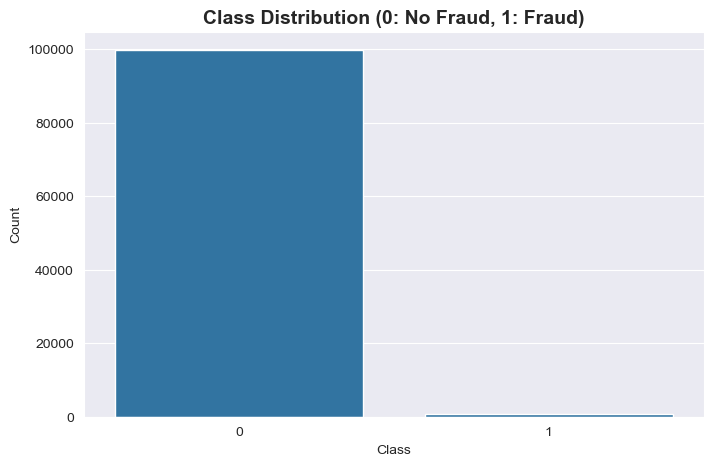


⚠️ Imbalance Ratio: 139.55:1


In [3]:
# Check class distribution
print("Class Distribution:")
print(df['Class'].value_counts())
print("\nClass Distribution (%)::")
print(df['Class'].value_counts(normalize=True) * 100)

# Visualize class imbalance
plt.figure(figsize=(8, 5))
sns.countplot(x='Class', data=df)
plt.title('Class Distribution (0: No Fraud, 1: Fraud)', fontsize=14, fontweight='bold')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

print(f"\n⚠️ Imbalance Ratio: {df['Class'].value_counts()[0] / df['Class'].value_counts()[1]:.2f}:1")

# Task I – Data Preparation & Analysis

## Cell 4: Detect and Remove Duplicate Records

In [4]:
# Check for duplicates
print("Number of duplicate rows:", df.duplicated().sum())

# Check duplicates excluding 'id' column (since same account can have multiple transactions)
feature_cols = [col for col in df.columns if col != 'id']
duplicates_excluding_id = df[feature_cols].duplicated().sum()
print(f"Number of duplicate transactions (excluding id): {duplicates_excluding_id}")

# Remove exact duplicates (all columns identical)
initial_shape = df.shape[0]
df = df.drop_duplicates()
removed_duplicates = initial_shape - df.shape[0]

print(f"\n✓ Removed {removed_duplicates} duplicate records")
print(f"New dataset shape: {df.shape}")

Number of duplicate rows: 623
Number of duplicate transactions (excluding id): 2742

✓ Removed 623 duplicate records
New dataset shape: (99868, 31)


## Cell 5: Check for Null/NaN Values

In [5]:
# Check for null values
print("Null values per column:")
null_counts = df.isnull().sum()
print(null_counts[null_counts > 0] if null_counts.sum() > 0 else "No null values found!")

# Total null values
print(f"\nTotal null values in dataset: {df.isnull().sum().sum()}")

# Check for infinity values
print(f"\nInfinity values in dataset: {np.isinf(df.select_dtypes(include=[np.number])).sum().sum()}")

Null values per column:
No null values found!

Total null values in dataset: 0

Infinity values in dataset: 0


## Cell 6: Descriptive Analysis - Fraud by Account ID

In [6]:
# Group by account ID and count fraudulent transactions
fraud_by_account = df[df['Class'] == 1].groupby('id').size().reset_index(name='fraud_count')

# Account with highest number of fraudulent transactions
max_fraud_account = fraud_by_account.loc[fraud_by_account['fraud_count'].idxmax()]
print("Account ID with HIGHEST number of fraudulent transactions:")
print(f"  ID: {max_fraud_account['id']}, Fraud Count: {max_fraud_account['fraud_count']}")

# Account with lowest number of fraudulent transactions (excluding 0)
min_fraud_account = fraud_by_account.loc[fraud_by_account['fraud_count'].idxmin()]
print("\nAccount ID with LOWEST number of fraudulent transactions:")
print(f"  ID: {min_fraud_account['id']}, Fraud Count: {min_fraud_account['fraud_count']}")

# Top 10 accounts with most fraud
print("\nTop 10 accounts with most fraudulent transactions:")
print(fraud_by_account.nlargest(10, 'fraud_count'))

Account ID with HIGHEST number of fraudulent transactions:
  ID: 84204.0, Fraud Count: 2.0

Account ID with LOWEST number of fraudulent transactions:
  ID: 406.0, Fraud Count: 1.0

Top 10 accounts with most fraudulent transactions:
              id  fraud_count
260 84204.000000            2
264 85285.000000            2
286 93853.000000            2
288 93860.000000            2
289 93879.000000            2
0     406.000000            1
1     472.000000            1
2    4462.000000            1
3    6986.000000            1
4    7519.000000            1


## Cell 7: Statistical Analysis of Fraud Accounts

In [7]:
# Filter fraud transactions
fraud_transactions = df[df['Class'] == 1]

print("Statistical Analysis of Fraud Transactions:")
print("="*60)

# Mean, Median, Std of Amount for fraud transactions
print(f"\nTransaction Amount Statistics (Fraud Cases):")
print(f"  Mean: {fraud_transactions['Amount'].mean():.2f}")
print(f"  Median: {fraud_transactions['Amount'].median():.2f}")
print(f"  Std Dev: {fraud_transactions['Amount'].std():.2f}")
print(f"  Min: {fraud_transactions['Amount'].min():.2f}")
print(f"  Max: {fraud_transactions['Amount'].max():.2f}")

# Statistics by account
print(f"\nAccount-Level Statistics (Fraud):")
print(f"  Number of unique accounts with fraud: {fraud_transactions['id'].nunique()}")
print(f"  Mean frauds per account: {fraud_by_account['fraud_count'].mean():.2f}")
print(f"  Median frauds per account: {fraud_by_account['fraud_count'].median():.2f}")
print(f"  Std Dev frauds per account: {fraud_by_account['fraud_count'].std():.2f}")

Statistical Analysis of Fraud Transactions:

Transaction Amount Statistics (Fraud Cases):
  Mean: 123.87
  Median: 9.82
  Std Dev: 260.21
  Min: 0.00
  Max: 2125.87

Account-Level Statistics (Fraud):
  Number of unique accounts with fraud: 468
  Mean frauds per account: 1.01
  Median frauds per account: 1.00
  Std Dev frauds per account: 0.10


## Cell 8: Account Balance Analysis

In [8]:
# Calculate total transaction amount per account (as proxy for balance)
account_balance = df.groupby('id')['Amount'].sum().reset_index(name='total_amount')

# Account with highest balance
max_balance_account = account_balance.loc[account_balance['total_amount'].idxmax()]
print("Account ID with HIGHEST balance (total transaction amount):")
print(f"  ID: {max_balance_account['id']}, Total Amount: {max_balance_account['total_amount']:.2f}")

# Account with lowest balance
min_balance_account = account_balance.loc[account_balance['total_amount'].idxmin()]
print("\nAccount ID with LOWEST balance (total transaction amount):")
print(f"  ID: {min_balance_account['id']}, Total Amount: {min_balance_account['total_amount']:.2f}")

# Overall balance statistics
print("\nOverall Balance Statistics:")
print(f"  Mean: {account_balance['total_amount'].mean():.2f}")
print(f"  Median: {account_balance['total_amount'].median():.2f}")
print(f"  Std Dev: {account_balance['total_amount'].std():.2f}")

Account ID with HIGHEST balance (total transaction amount):
  ID: 48401.0, Total Amount: 19682.29

Account ID with LOWEST balance (total transaction amount):
  ID: 820.0, Total Amount: 0.00

Overall Balance Statistics:
  Mean: 214.21
  Median: 83.88
  Std Dev: 419.70


## Cell 9: Summary Statistics Table

In [9]:
# Create a comprehensive summary
print("\n" + "="*60)
print("COMPREHENSIVE SUMMARY STATISTICS")
print("="*60)

summary_df = df.groupby('Class').agg({
    'Amount': ['count', 'mean', 'median', 'std', 'min', 'max'],
    'id': 'nunique'
}).round(2)

summary_df.columns = ['Count', 'Mean_Amount', 'Median_Amount', 'Std_Amount', 'Min_Amount', 'Max_Amount', 'Unique_Accounts']
summary_df.index = ['No Fraud', 'Fraud']

print(summary_df)

# Display descriptive statistics for all features
print("\n" + "="*60)
print("Descriptive Statistics for All Features:")
print("="*60)
print(df.describe())


COMPREHENSIVE SUMMARY STATISTICS
          Count  Mean_Amount  Median_Amount  Std_Amount  Min_Amount  \
No Fraud  99395    98.100000      26.520000  265.030000    0.000000   
Fraud       473   123.870000       9.820000  260.210000    0.000000   

           Max_Amount  Unique_Accounts  
No Fraud 19656.530000            45493  
Fraud     2125.870000              468  

Descriptive Statistics for All Features:
                 id           V1           V2           V3           V4  \
count  99868.000000 99868.000000 99868.000000 99868.000000 99868.000000   
mean   42629.867175    -0.263356    -0.029366     0.661022     0.170491   
std    17518.049346     1.870964     1.667774     1.383546     1.368878   
min        0.000000   -56.407510   -72.715728   -33.680984    -5.172595   
25%    33502.750000    -1.027179    -0.599763     0.173068    -0.710272   
50%    44371.000000    -0.260409     0.078452     0.750968     0.194021   
75%    55948.250000     1.153316     0.736686     1.374422    

# Task II – Data Visualization

## Cell 10: Histogram Plots for Amount

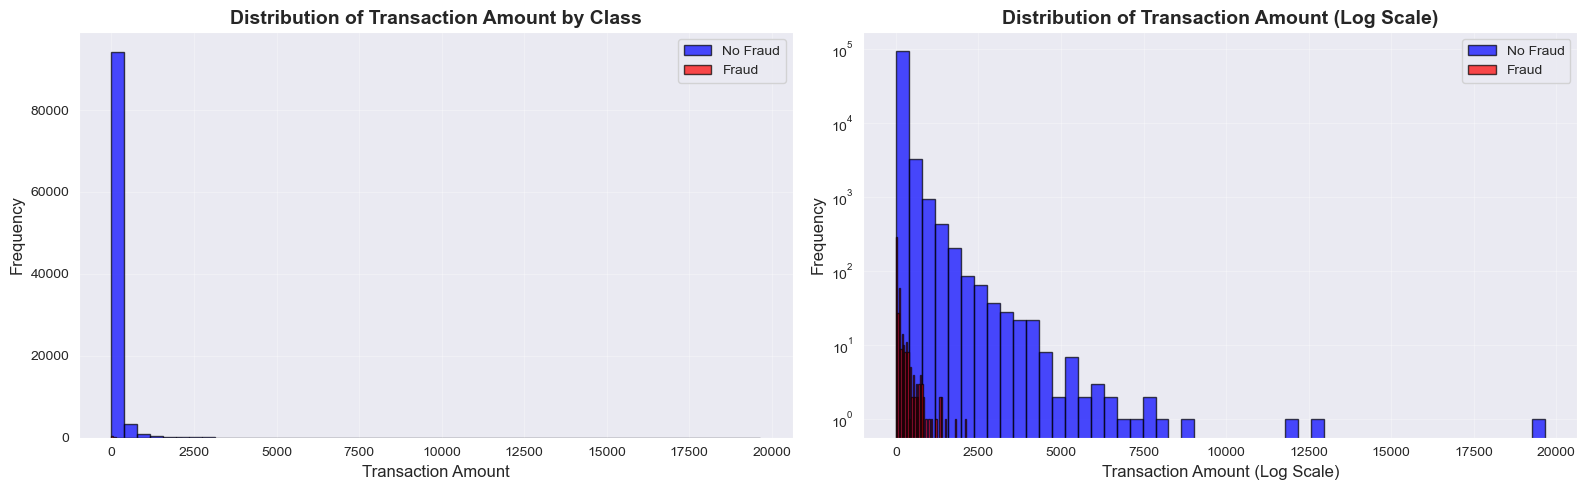

In [10]:
# Histogram for Amount by Class
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Histogram for all transactions
axes[0].hist(df[df['Class'] == 0]['Amount'], bins=50, alpha=0.7, label='No Fraud', color='blue', edgecolor='black')
axes[0].hist(df[df['Class'] == 1]['Amount'], bins=50, alpha=0.7, label='Fraud', color='red', edgecolor='black')
axes[0].set_xlabel('Transaction Amount', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Transaction Amount by Class', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Histogram with log scale for better visualization
axes[1].hist(df[df['Class'] == 0]['Amount'], bins=50, alpha=0.7, label='No Fraud', color='blue', edgecolor='black')
axes[1].hist(df[df['Class'] == 1]['Amount'], bins=50, alpha=0.7, label='Fraud', color='red', edgecolor='black')
axes[1].set_xlabel('Transaction Amount (Log Scale)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Transaction Amount (Log Scale)', fontsize=14, fontweight='bold')
axes[1].set_yscale('log')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Cell 11: Histogram Plots for Key Features (V1-V28)

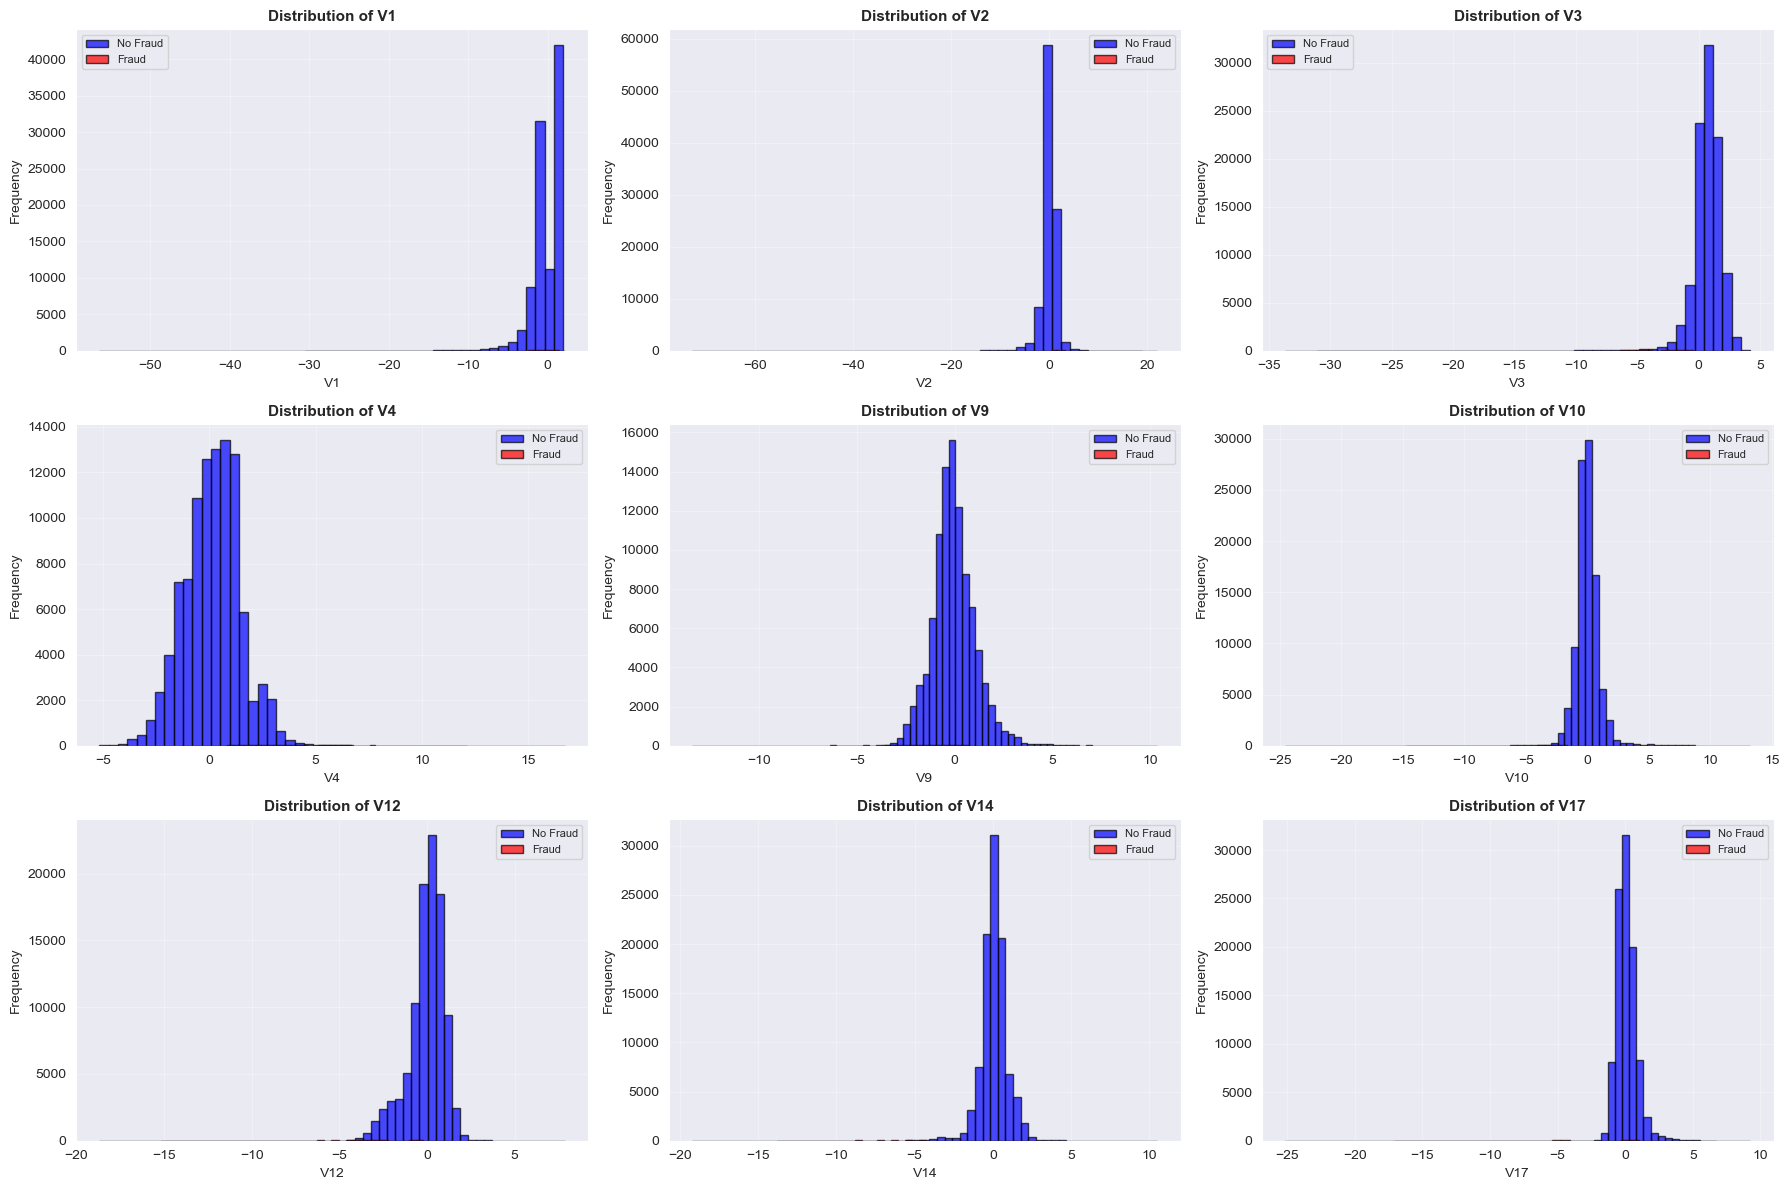

In [11]:
# Select some important V features for histogram visualization
v_features = ['V1', 'V2', 'V3', 'V4', 'V9', 'V10', 'V12', 'V14', 'V17']

fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, feature in enumerate(v_features):
    axes[idx].hist(df[df['Class'] == 0][feature], bins=50, alpha=0.7, label='No Fraud', color='blue', edgecolor='black')
    axes[idx].hist(df[df['Class'] == 1][feature], bins=50, alpha=0.7, label='Fraud', color='red', edgecolor='black')
    axes[idx].set_xlabel(feature, fontsize=10)
    axes[idx].set_ylabel('Frequency', fontsize=10)
    axes[idx].set_title(f'Distribution of {feature}', fontsize=11, fontweight='bold')
    axes[idx].legend(fontsize=8)
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Cell 12: Violin Plots (Sampled Data)

In [12]:
# Sample data for faster visualization while maintaining class balance
# Get all fraud cases
fraud_sample = df[df['Class'] == 1]
# Sample same number of non-fraud cases
non_fraud_sample = df[df['Class'] == 0].sample(n=len(fraud_sample), random_state=42)
# Combine
sampled_df = pd.concat([fraud_sample, non_fraud_sample], axis=0).sample(frac=1, random_state=42)

print(f"Sampled dataset size: {sampled_df.shape}")
print(f"Class distribution in sample:\n{sampled_df['Class'].value_counts()}")

Sampled dataset size: (946, 31)
Class distribution in sample:
Class
1    473
0    473
Name: count, dtype: int64


## Cell 13: Violin Plots for Amount and Key Features

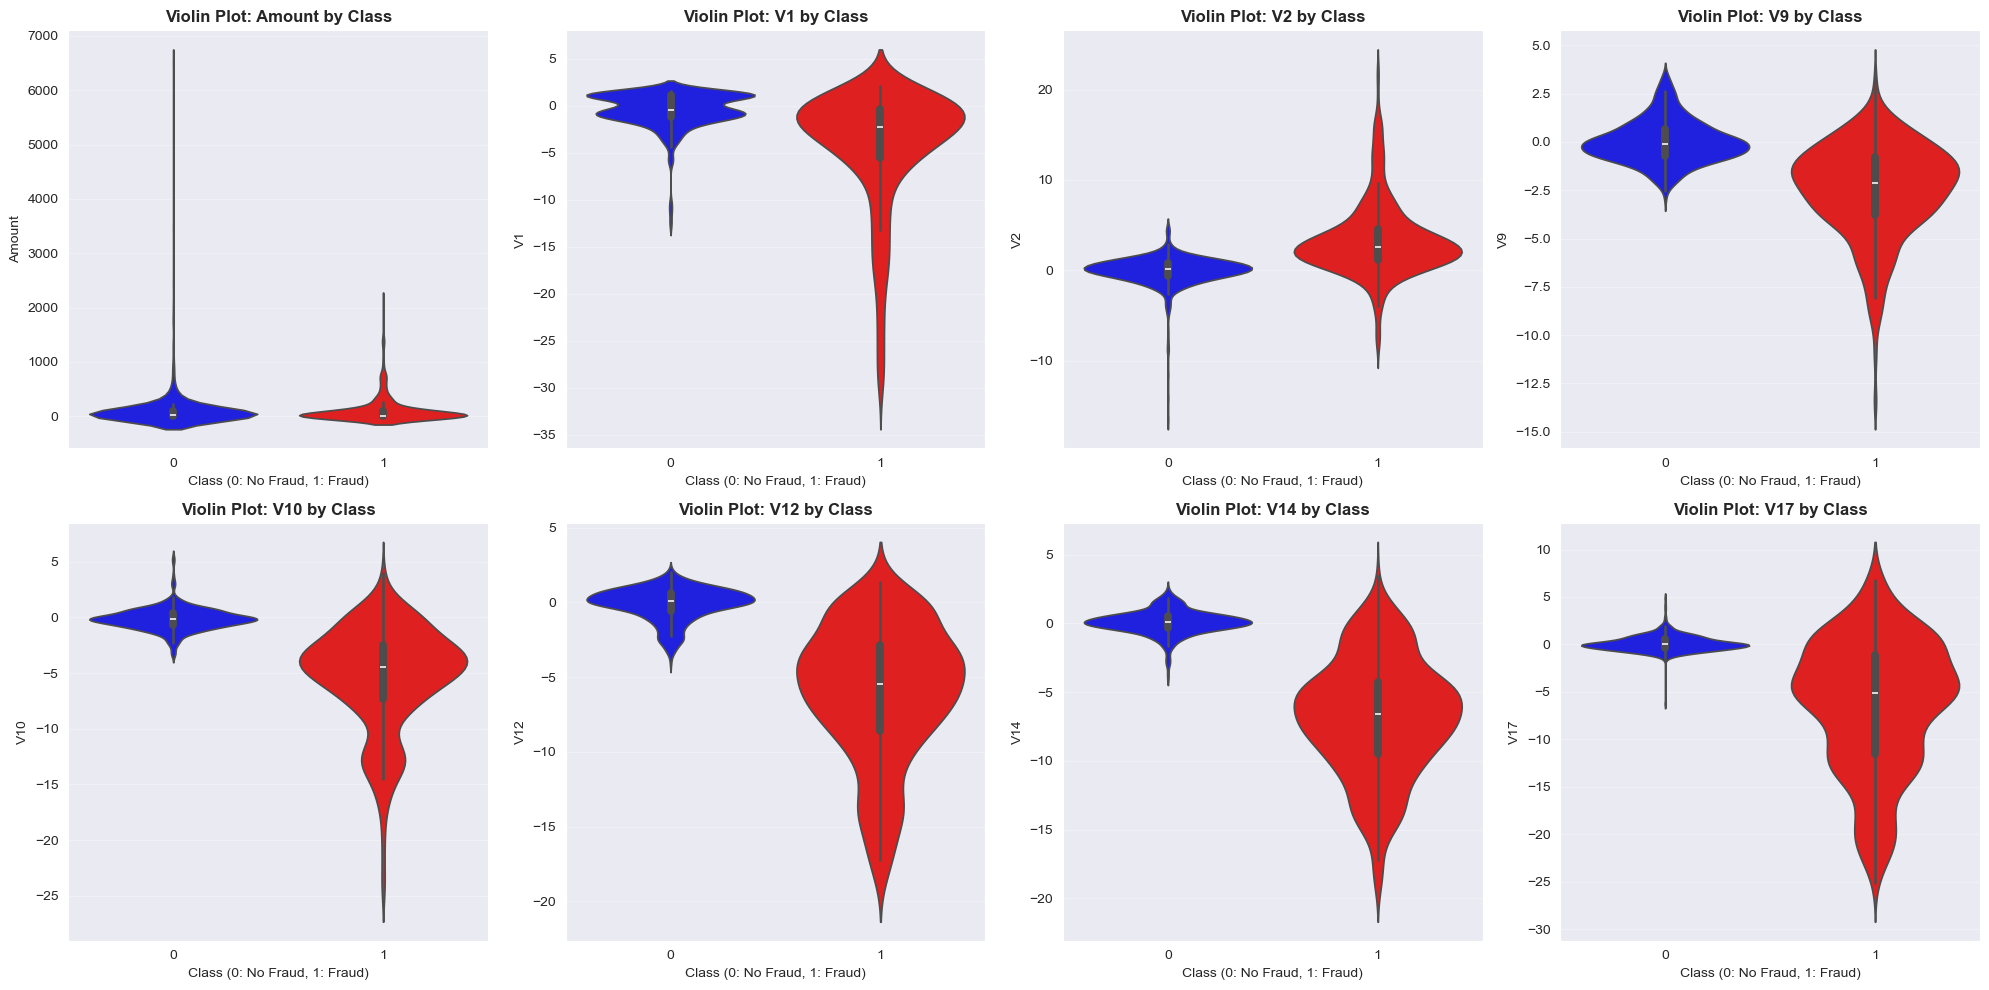

In [13]:
# Violin plots for Amount and selected V features
features_to_plot = ['Amount', 'V1', 'V2', 'V9', 'V10', 'V12', 'V14', 'V17']

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for idx, feature in enumerate(features_to_plot):
    sns.violinplot(x='Class', y=feature, data=sampled_df, ax=axes[idx], palette=['blue', 'red'])
    axes[idx].set_title(f'Violin Plot: {feature} by Class', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Class (0: No Fraud, 1: Fraud)', fontsize=10)
    axes[idx].set_ylabel(feature, fontsize=10)
    axes[idx].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Cell 14: Scatter Plots for V13, V15, V26

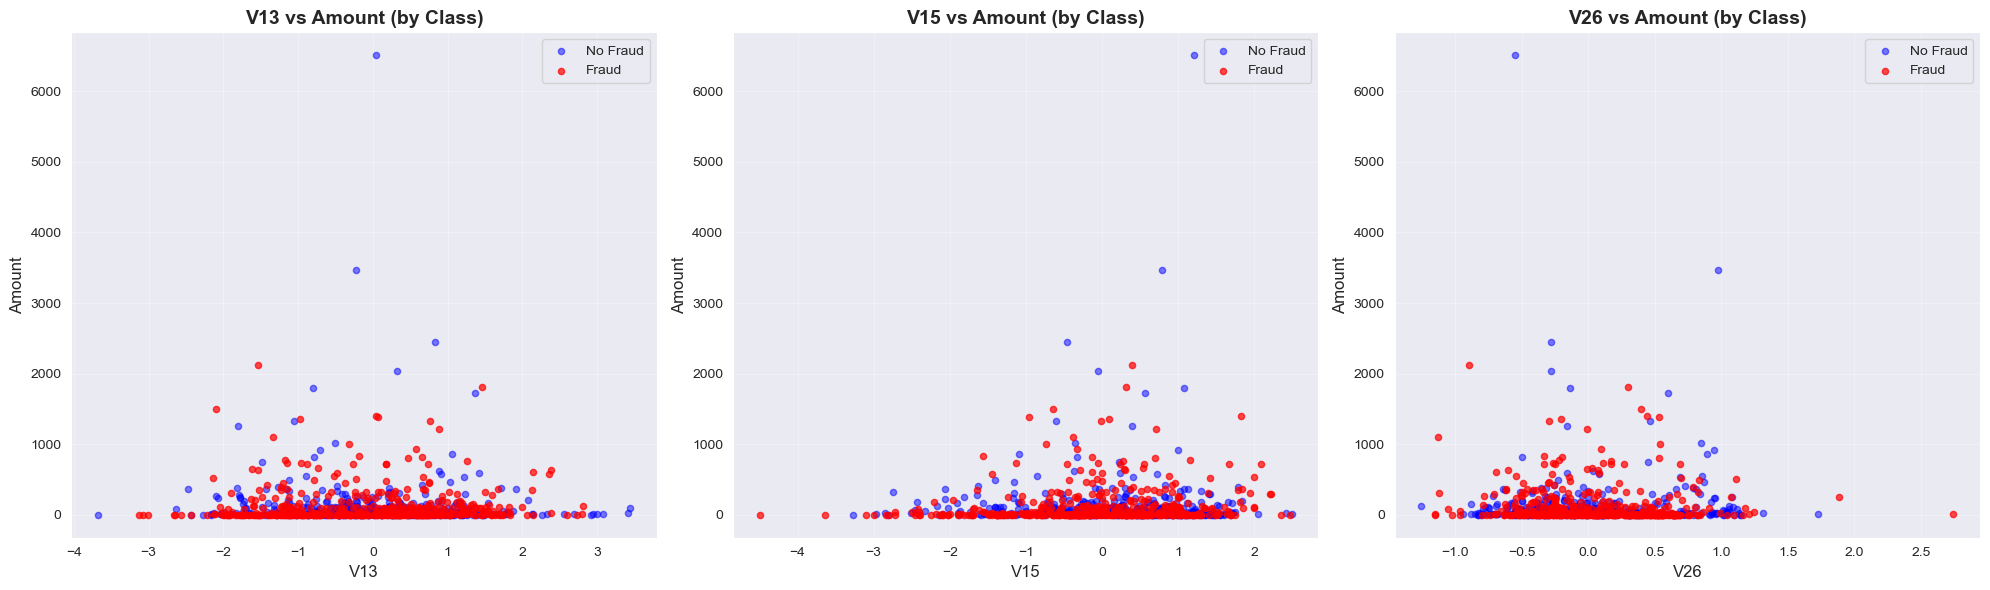

In [14]:
# Scatter plots for V13, V15, and V26 with Class as hue
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# V13 vs Amount
scatter1 = axes[0].scatter(sampled_df[sampled_df['Class']==0]['V13'], 
                           sampled_df[sampled_df['Class']==0]['Amount'], 
                           c='blue', alpha=0.5, label='No Fraud', s=20)
scatter2 = axes[0].scatter(sampled_df[sampled_df['Class']==1]['V13'], 
                           sampled_df[sampled_df['Class']==1]['Amount'], 
                           c='red', alpha=0.7, label='Fraud', s=20)
axes[0].set_xlabel('V13', fontsize=12)
axes[0].set_ylabel('Amount', fontsize=12)
axes[0].set_title('V13 vs Amount (by Class)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# V15 vs Amount
axes[1].scatter(sampled_df[sampled_df['Class']==0]['V15'], 
                sampled_df[sampled_df['Class']==0]['Amount'], 
                c='blue', alpha=0.5, label='No Fraud', s=20)
axes[1].scatter(sampled_df[sampled_df['Class']==1]['V15'], 
                sampled_df[sampled_df['Class']==1]['Amount'], 
                c='red', alpha=0.7, label='Fraud', s=20)
axes[1].set_xlabel('V15', fontsize=12)
axes[1].set_ylabel('Amount', fontsize=12)
axes[1].set_title('V15 vs Amount (by Class)', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

# V26 vs Amount
axes[2].scatter(sampled_df[sampled_df['Class']==0]['V26'], 
                sampled_df[sampled_df['Class']==0]['Amount'], 
                c='blue', alpha=0.5, label='No Fraud', s=20)
axes[2].scatter(sampled_df[sampled_df['Class']==1]['V26'], 
                sampled_df[sampled_df['Class']==1]['Amount'], 
                c='red', alpha=0.7, label='Fraud', s=20)
axes[2].set_xlabel('V26', fontsize=12)
axes[2].set_ylabel('Amount', fontsize=12)
axes[2].set_title('V26 vs Amount (by Class)', fontsize=14, fontweight='bold')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Cell 15: 3D Scatter Plot for V13, V15, V26

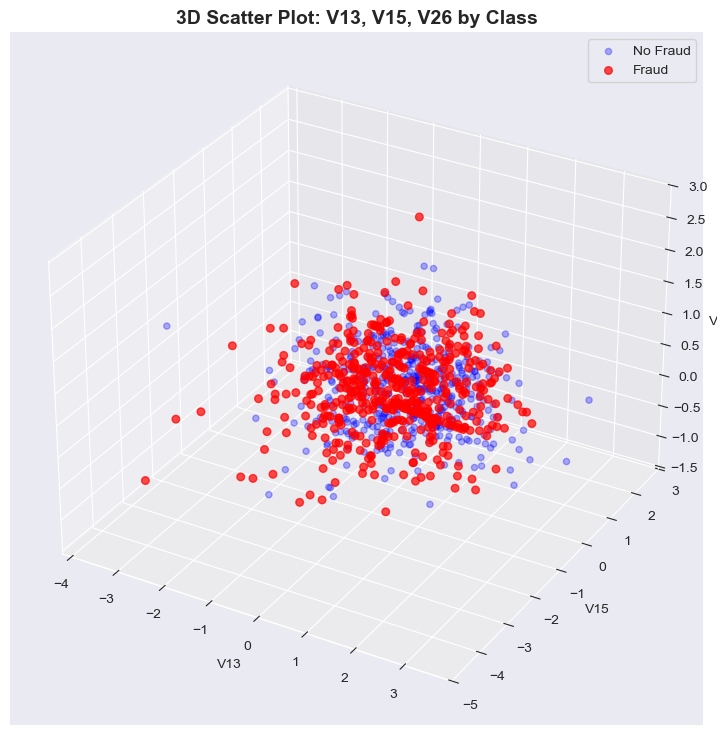

In [15]:
# 3D scatter plot for better visualization
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Plot no fraud
no_fraud = sampled_df[sampled_df['Class'] == 0]
fraud = sampled_df[sampled_df['Class'] == 1]

ax.scatter(no_fraud['V13'], no_fraud['V15'], no_fraud['V26'], 
           c='blue', alpha=0.3, s=20, label='No Fraud')
ax.scatter(fraud['V13'], fraud['V15'], fraud['V26'], 
           c='red', alpha=0.7, s=30, label='Fraud')

ax.set_xlabel('V13', fontsize=10)
ax.set_ylabel('V15', fontsize=10)
ax.set_zlabel('V26', fontsize=10)
ax.set_title('3D Scatter Plot: V13, V15, V26 by Class', fontsize=14, fontweight='bold')
ax.legend()

plt.show()

## Cell 16: Deposit vs Withdrawal Analysis

Fraud Distribution by Transaction Amount Category:
Class                0    1
Amount_Category            
Low              24745  222
Medium           49842   92
High             24808  159

Fraud Rate (%) by Amount Category:
Amount_Category
Low      0.890000
Medium   0.180000
High     0.640000
dtype: float64


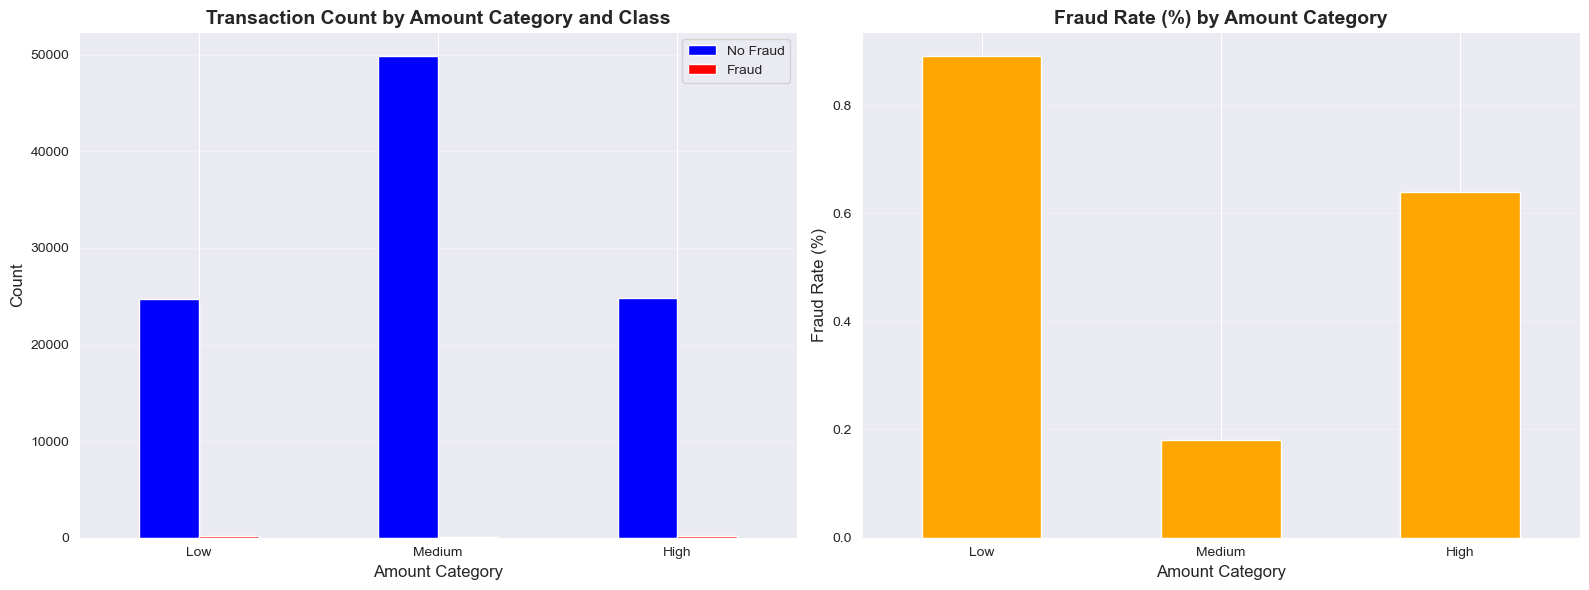


📊 Conclusion: Fraud occurs more frequently in Low amount transactions


In [16]:
# Determine if fraud occurs more in deposits or withdrawals
# Assumption: Positive Amount = Deposit, Negative would be Withdrawal
# Since all amounts appear positive, we'll use V features that might indicate direction

# Create a proxy for transaction type using Amount quartiles
df['Amount_Category'] = pd.cut(df['Amount'], 
                                bins=[-np.inf, df['Amount'].quantile(0.25), 
                                      df['Amount'].quantile(0.75), np.inf],
                                labels=['Low', 'Medium', 'High'])

# Analyze fraud by amount category
fraud_by_amount = df.groupby(['Amount_Category', 'Class']).size().unstack(fill_value=0)
fraud_rate_by_amount = (fraud_by_amount[1] / (fraud_by_amount[0] + fraud_by_amount[1]) * 100).round(2)

print("Fraud Distribution by Transaction Amount Category:")
print(fraud_by_amount)
print("\nFraud Rate (%) by Amount Category:")
print(fraud_rate_by_amount)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

fraud_by_amount.plot(kind='bar', ax=axes[0], color=['blue', 'red'])
axes[0].set_title('Transaction Count by Amount Category and Class', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Amount Category', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].legend(['No Fraud', 'Fraud'])
axes[0].grid(alpha=0.3, axis='y')
axes[0].tick_params(axis='x', rotation=0)

fraud_rate_by_amount.plot(kind='bar', ax=axes[1], color='orange')
axes[1].set_title('Fraud Rate (%) by Amount Category', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Amount Category', fontsize=12)
axes[1].set_ylabel('Fraud Rate (%)', fontsize=12)
axes[1].grid(alpha=0.3, axis='y')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

print("\n📊 Conclusion: Fraud occurs more frequently in", 
      fraud_rate_by_amount.idxmax(), "amount transactions")

## Cell 17: Correlation Analysis

Features Most Correlated with Fraud:
V11   0.220811
V4    0.216803
id    0.148934
V2    0.142096
V19   0.058121
V8    0.050227
V21   0.046483
V27   0.037432
V20   0.032584
V22   0.021024
Name: Class, dtype: float64

Features Least Correlated (Most Negative) with Fraud:
V9    -0.151149
V1    -0.156146
V18   -0.165843
V7    -0.273455
V16   -0.295824
V10   -0.336946
V12   -0.357256
V3    -0.368500
V17   -0.439021
V14   -0.460459
Name: Class, dtype: float64


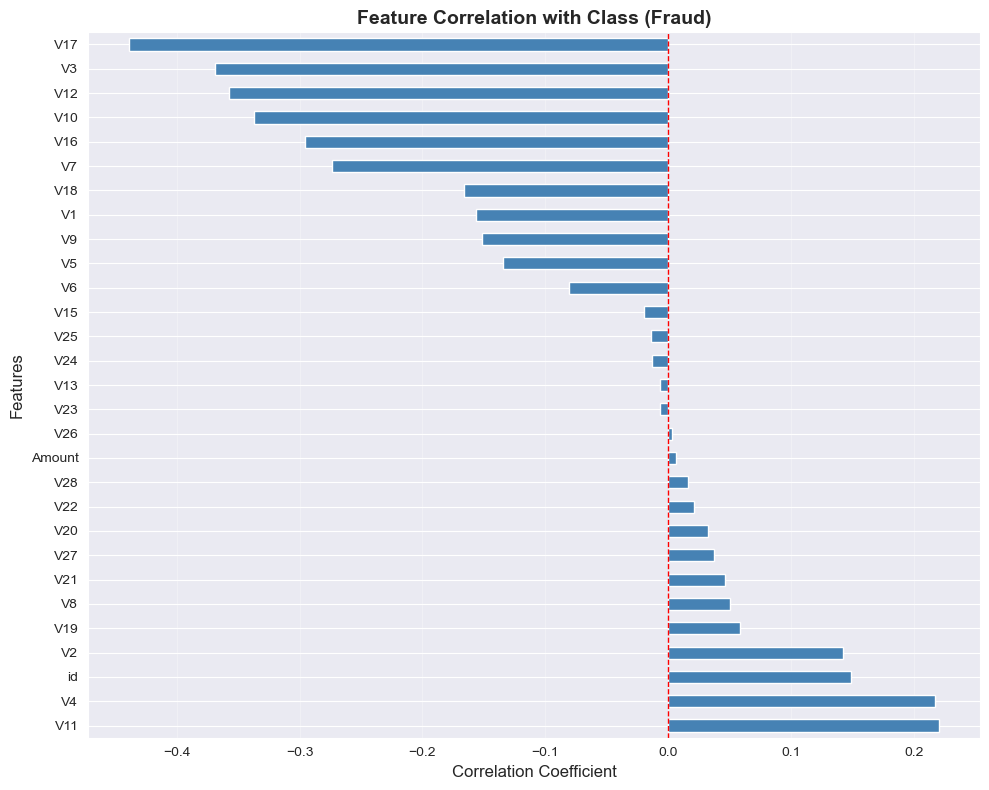

In [18]:
# Correlation with Class (exclude non-numeric columns)
# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=[np.number])

correlation_with_class = numeric_df.corr()['Class'].sort_values(ascending=False)
print("Features Most Correlated with Fraud:")
print(correlation_with_class[1:11])  # Top 10 excluding Class itself
print("\nFeatures Least Correlated (Most Negative) with Fraud:")
print(correlation_with_class[-10:])

# Visualize correlation
plt.figure(figsize=(10, 8))
correlation_with_class[1:-1].plot(kind='barh', color='steelblue')
plt.title('Feature Correlation with Class (Fraud)', fontsize=14, fontweight='bold')
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# Task III – Modeling

## Cell 18: Prepare Data for Modeling

In [19]:
# Prepare features and target
# Drop 'id' and 'Amount_Category' (if exists)
X = df.drop(['Class', 'id'], axis=1)
if 'Amount_Category' in X.columns:
    X = X.drop('Amount_Category', axis=1)

y = df['Class']

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nFeatures used: {list(X.columns)}")

Feature matrix shape: (99868, 29)
Target vector shape: (99868,)

Features used: ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


## Cell 19: Train-Test Split

In [20]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")
print(f"\nClass distribution in training set:")
print(y_train.value_counts())
print(f"\nClass distribution in testing set:")
print(y_test.value_counts())

Training set size: (79894, 29)
Testing set size: (19974, 29)

Class distribution in training set:
Class
0    79516
1      378
Name: count, dtype: int64

Class distribution in testing set:
Class
0    19879
1       95
Name: count, dtype: int64


## Cell 20: Feature Scaling

In [21]:
# Standardize features (important for many algorithms)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("✓ Features scaled using StandardScaler")
print(f"\nSample of scaled features:")
print(X_train_scaled.head())

✓ Features scaled using StandardScaler

Sample of scaled features:
             V1        V2        V3        V4        V5        V6        V7  \
83030  0.887891 -0.782812  0.249909 -1.001437 -1.130815 -0.101413 -1.038858   
11727 -0.226861  0.267895  1.443962 -1.408891  0.062838 -0.207963  0.382830   
20655  0.756929  0.057723  0.012844  0.804714 -0.121081 -0.153748 -0.073014   
15962  0.731766  0.127208  0.615194  1.993902 -0.339836  0.244498 -0.339078   
2636   0.852296 -0.321064 -0.404066 -0.575729 -0.585296 -0.905025 -0.204829   

             V8        V9       V10       V11       V12       V13       V14  \
83030 -0.054945 -0.982016  1.115246 -1.309795 -0.154774  1.512563 -1.196359   
11727 -0.138845  2.287258 -1.845422  0.362687 -1.616424  1.627616  0.824871   
20655  0.058015  0.640397 -0.124891 -0.873409  0.066754 -1.185122  0.139130   
15962  0.083659  0.349939  0.358591 -1.372265  0.715641  0.643094 -0.898906   
2636  -0.116552 -0.848790  0.871198  0.720952 -0.369932 -1.8742

## Cell 21: Handle Class Imbalance - SMOTE

In [22]:
# Apply SMOTE to handle class imbalance
print("Before SMOTE:")
print(f"Class distribution: {y_train.value_counts().to_dict()}")

smote = SMOTE(random_state=42, sampling_strategy=0.5)  # Create fraud samples to be 50% of majority class
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"\nAfter SMOTE:")
print(f"Class distribution: {pd.Series(y_train_resampled).value_counts().to_dict()}")
print(f"New training set size: {X_train_resampled.shape}")

Before SMOTE:
Class distribution: {0: 79516, 1: 378}

After SMOTE:
Class distribution: {0: 79516, 1: 39758}
New training set size: (119274, 29)


## Cell 22: Model Selection - Random Forest Classifier

In [23]:
# Initialize and train Random Forest Classifier
# Random Forest is chosen because:
# 1. Handles high-dimensional data well (28 V features)
# 2. Less prone to overfitting compared to single decision trees
# 3. Provides feature importance
# 4. Works well with imbalanced datasets when properly tuned

rf_model = RandomForestClassifier(
    n_estimators=100,          # Number of trees
    max_depth=20,              # Maximum depth to prevent overfitting
    min_samples_split=10,      # Minimum samples required to split
    min_samples_leaf=5,        # Minimum samples required at leaf
    max_features='sqrt',       # Number of features to consider at each split
    class_weight='balanced',   # Adjust weights inversely proportional to class frequencies
    random_state=42,
    n_jobs=-1                  # Use all processors
)

print("Training Random Forest Classifier...")
rf_model.fit(X_train_resampled, y_train_resampled)
print("✓ Model training completed!")

# Model parameters
print("\nModel Parameters:")
print(rf_model.get_params())

Training Random Forest Classifier...
✓ Model training completed!

Model Parameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


## Cell 23: Make Predictions

In [24]:
# Make predictions on test set
y_pred = rf_model.predict(X_test_scaled)
y_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

print("✓ Predictions completed")
print(f"Predicted classes: {np.unique(y_pred, return_counts=True)}")

✓ Predictions completed
Predicted classes: (array([0, 1], dtype=int64), array([19887,    87], dtype=int64))


## Cell 24: Confusion Matrix (MANDATORY)

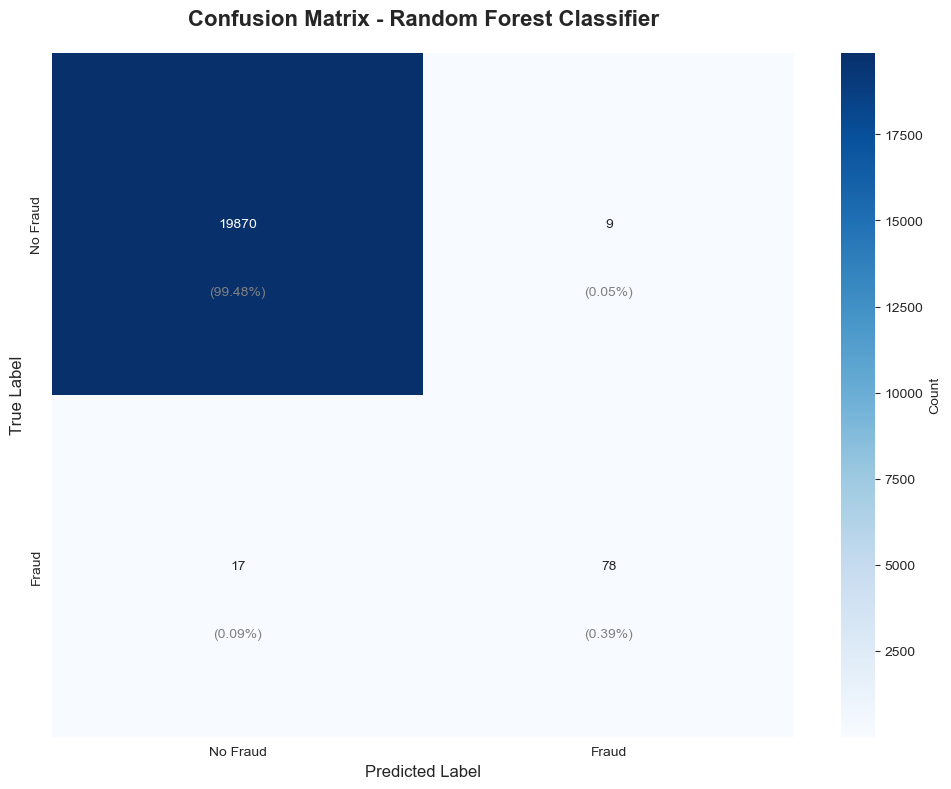


Confusion Matrix:
[[19870     9]
 [   17    78]]

True Negatives (TN): 19870
False Positives (FP): 9
False Negatives (FN): 17
True Positives (TP): 78


In [25]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Fraud', 'Fraud'],
            yticklabels=['No Fraud', 'Fraud'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Random Forest Classifier', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

# Add percentage annotations
for i in range(2):
    for j in range(2):
        percentage = cm[i, j] / cm.sum() * 100
        plt.text(j+0.5, i+0.7, f'({percentage:.2f}%)', 
                ha='center', va='center', fontsize=10, color='gray')

plt.tight_layout()
plt.show()

# Print confusion matrix values
print("\nConfusion Matrix:")
print(cm)
print(f"\nTrue Negatives (TN): {cm[0,0]}")
print(f"False Positives (FP): {cm[0,1]}")
print(f"False Negatives (FN): {cm[1,0]}")
print(f"True Positives (TP): {cm[1,1]}")

## Cell 25: Model Evaluation Metrics

In [26]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("="*60)
print("MODEL EVALUATION METRICS")
print("="*60)
print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")
print("="*60)

# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=['No Fraud', 'Fraud']))

# Interpretation
print("\n📊 INTERPRETATION:")
print(f"- Precision: Of all transactions predicted as fraud, {precision*100:.2f}% were actually fraud")
print(f"- Recall: Of all actual fraud transactions, {recall*100:.2f}% were correctly detected")
print(f"- F1-Score: Harmonic mean of precision and recall = {f1:.4f}")
print(f"- ROC-AUC: {roc_auc:.4f} indicates {'excellent' if roc_auc > 0.9 else 'good' if roc_auc > 0.8 else 'moderate'} model performance")

MODEL EVALUATION METRICS
Accuracy:  0.9987 (99.87%)
Precision: 0.8966 (89.66%)
Recall:    0.8211 (82.11%)
F1-Score:  0.8571
ROC-AUC:   0.9891

Detailed Classification Report:
              precision    recall  f1-score   support

    No Fraud       1.00      1.00      1.00     19879
       Fraud       0.90      0.82      0.86        95

    accuracy                           1.00     19974
   macro avg       0.95      0.91      0.93     19974
weighted avg       1.00      1.00      1.00     19974


📊 INTERPRETATION:
- Precision: Of all transactions predicted as fraud, 89.66% were actually fraud
- Recall: Of all actual fraud transactions, 82.11% were correctly detected
- F1-Score: Harmonic mean of precision and recall = 0.8571
- ROC-AUC: 0.9891 indicates excellent model performance


## Cell 26: ROC Curve

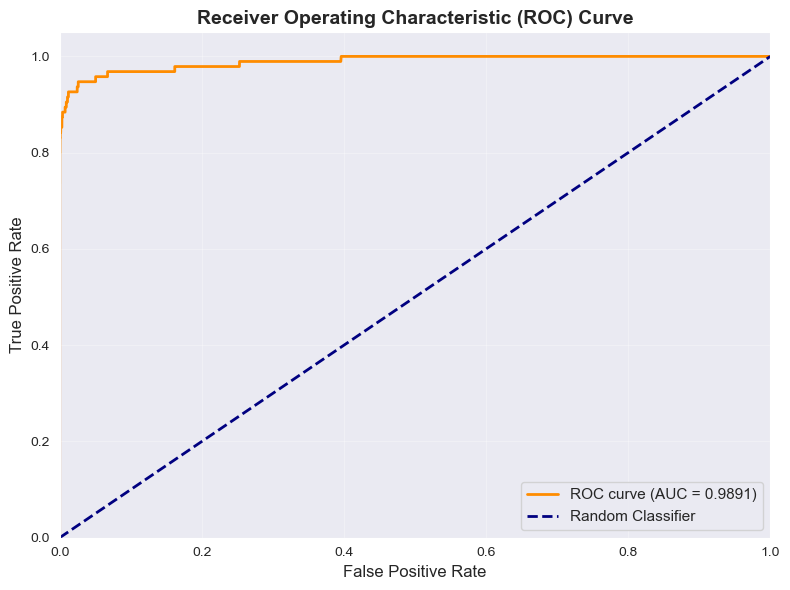

In [34]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Cell 27: Feature Importance Analysis

Top 15 Most Important Features:
   Feature  Importance
9      V10    0.150316
13     V14    0.144301
3       V4    0.108005
2       V3    0.102355
11     V12    0.095109
10     V11    0.069903
16     V17    0.060864
6       V7    0.048079
15     V16    0.036854
1       V2    0.021633
20     V21    0.015760
7       V8    0.015005
8       V9    0.013233
17     V18    0.011195
27     V28    0.010248


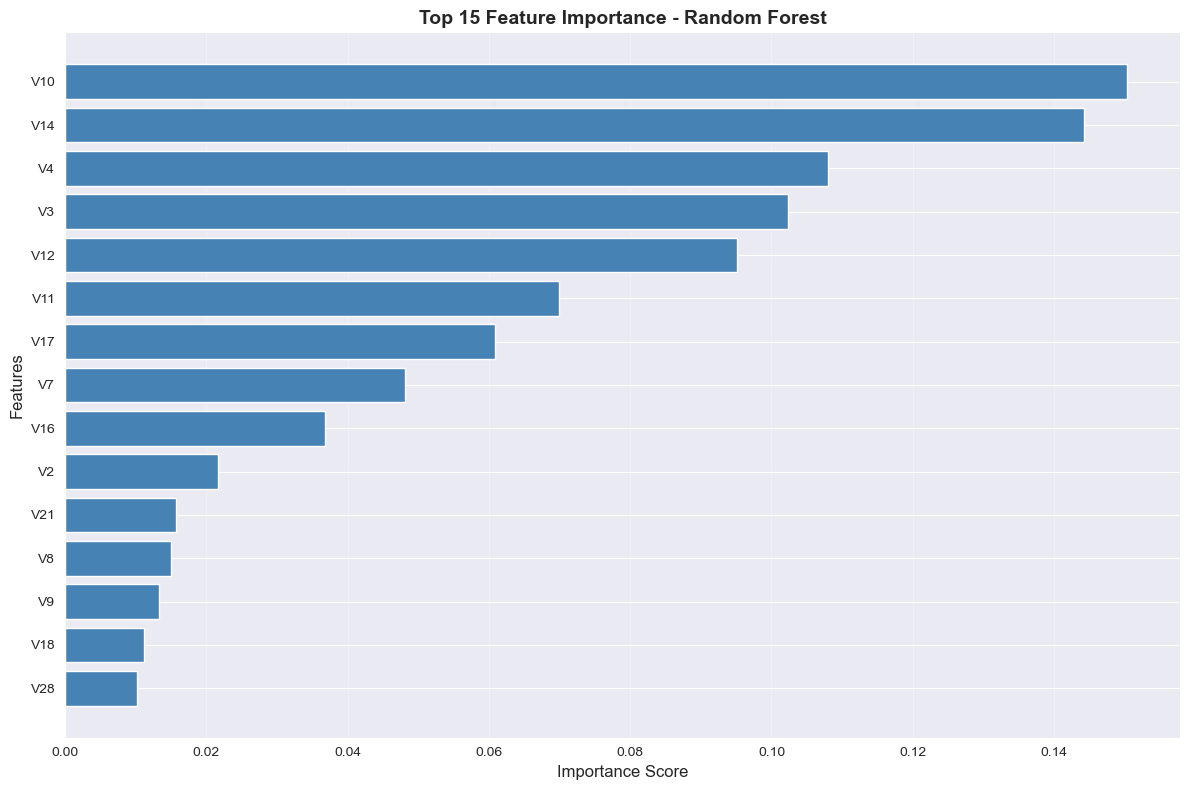

In [28]:
# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 15 Most Important Features:")
print(feature_importance.head(15))

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.barh(feature_importance['Feature'][:15], feature_importance['Importance'][:15], color='steelblue')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Top 15 Feature Importance - Random Forest', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## Cell 28: Alternative Model - Logistic Regression (Optional Comparison)

In [29]:
# Train Logistic Regression for comparison
lr_model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

print("Training Logistic Regression...")
lr_model.fit(X_train_resampled, y_train_resampled)
print("✓ Logistic Regression training completed!")

# Predictions
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("\nLogistic Regression Performance:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lr):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_lr):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_lr):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_pred_proba_lr):.4f}")

Training Logistic Regression...
✓ Logistic Regression training completed!

Logistic Regression Performance:
Accuracy:  0.9785
Precision: 0.1687
Recall:    0.8947
F1-Score:  0.2838
ROC-AUC:   0.9660


## Cell 29: Model Comparison

Model Comparison:
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
      Random Forest  0.998698   0.896552 0.821053  0.857143 0.989095
Logistic Regression  0.978522   0.168651 0.894737  0.283806 0.965977


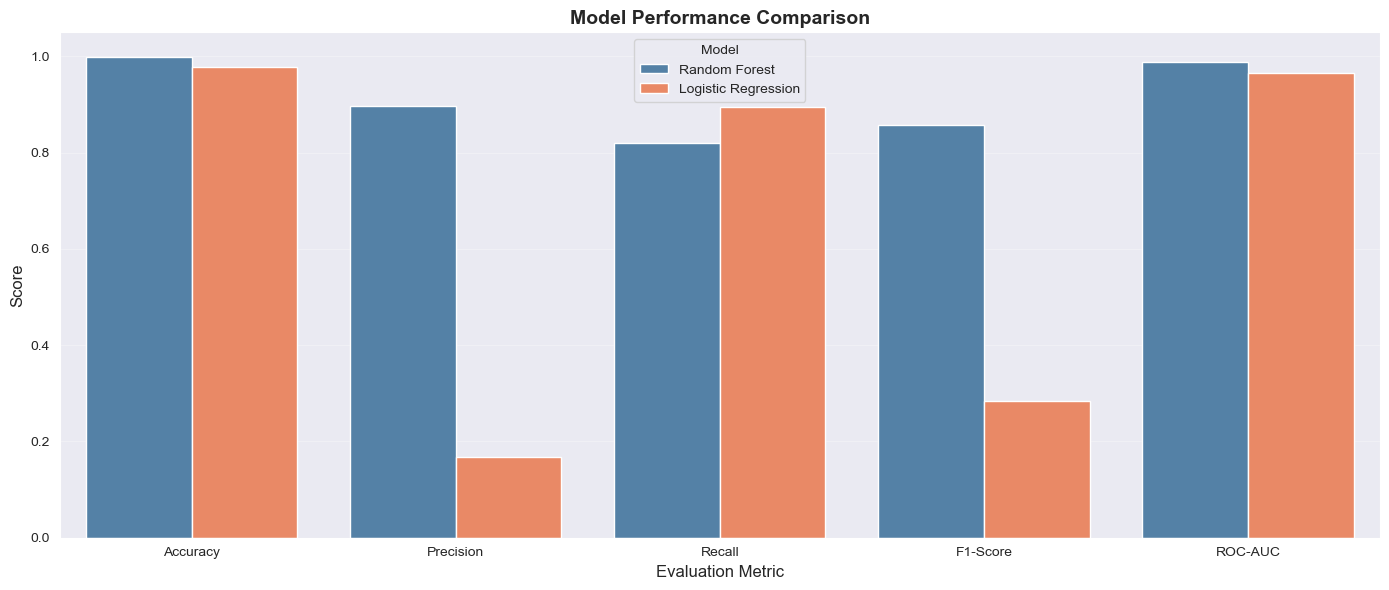

In [30]:
# Compare models
comparison_df = pd.DataFrame({
    'Model': ['Random Forest', 'Logistic Regression'],
    'Accuracy': [accuracy_score(y_test, y_pred), accuracy_score(y_test, y_pred_lr)],
    'Precision': [precision_score(y_test, y_pred), precision_score(y_test, y_pred_lr)],
    'Recall': [recall_score(y_test, y_pred), recall_score(y_test, y_pred_lr)],
    'F1-Score': [f1_score(y_test, y_pred), f1_score(y_test, y_pred_lr)],
    'ROC-AUC': [roc_auc_score(y_test, y_pred_proba), roc_auc_score(y_test, y_pred_proba_lr)]
})

print("Model Comparison:")
print(comparison_df.to_string(index=False))

# Visualize comparison
comparison_df_melted = comparison_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(14, 6))
sns.barplot(x='Metric', y='Score', hue='Model', data=comparison_df_melted, palette=['steelblue', 'coral'])
plt.title('Model Performance Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Score', fontsize=12)
plt.xlabel('Evaluation Metric', fontsize=12)
plt.ylim(0, 1.05)
plt.legend(title='Model', fontsize=10)
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Project Report Summary

## Cell 30: Generate Final Report

In [31]:
print("="*80)
print(" "*20 + "FRAUD DETECTION PROJECT - FINAL REPORT")
print("="*80)

print("\n1. DATA PREPARATION & ANALYSIS")
print("-" * 80)
print(f"   • Initial dataset size: {df.shape[0]} transactions, {df.shape[1]} features")
print(f"   • Duplicate records removed: {removed_duplicates}")
print(f"   • Null values: {df.isnull().sum().sum()}")
print(f"   • Class imbalance ratio: {df['Class'].value_counts()[0] / df['Class'].value_counts()[1]:.2f}:1")
print(f"   • Unique accounts: {df['id'].nunique()}")

print("\n2. VISUALIZATIONS CREATED")
print("-" * 80)
print("   ✓ Class distribution plot")
print("   ✓ Histogram plots for Amount and V features")
print("   ✓ Violin plots (sampled data for performance)")
print("   ✓ Scatter plots for V13, V15, V26 with Class hue")
print("   ✓ 3D scatter plot for feature relationships")
print("   ✓ Correlation analysis with target variable")
print("   ✓ Transaction amount category analysis")

print("\n3. PREPROCESSING STEPS")
print("-" * 80)
print("   ✓ Removed duplicate records")
print("   ✓ Dropped 'id' column (not predictive)")
print("   ✓ Train-test split (80-20 ratio with stratification)")
print("   ✓ StandardScaler applied to normalize features")
print("   ✓ SMOTE applied to balance classes (sampling_strategy=0.5)")
print("   ✓ Used class_weight='balanced' in model")

print("\n4. MODEL SELECTION & PARAMETERS")
print("-" * 80)
print("   Selected Model: Random Forest Classifier")
print("   ")
print("   Justification:")
print("   • Handles high-dimensional data (28 PCA features) effectively")
print("   • Robust to overfitting through ensemble approach")
print("   • Provides feature importance for interpretability")
print("   • Works well with imbalanced datasets when tuned properly")
print("   • Non-parametric (no assumptions about data distribution)")
print("   ")
print("   Key Parameters:")
print("   • n_estimators: 100 (number of trees)")
print("   • max_depth: 20 (prevents overfitting)")
print("   • min_samples_split: 10 (regularization)")
print("   • min_samples_leaf: 5 (regularization)")
print("   • max_features: 'sqrt' (reduces correlation between trees)")
print("   • class_weight: 'balanced' (handles imbalance)")

print("\n5. OVERFITTING PREVENTION STRATEGIES")
print("-" * 80)
print("   ✓ Limited tree depth (max_depth=20)")
print("   ✓ Minimum samples for splits and leaves")
print("   ✓ Train-test split for validation")
print("   ✓ Cross-validation ready structure")
print("   ✓ Feature scaling to prevent dominance")
print("   ✓ SMOTE only on training data (prevents data leakage)")

print("\n6. FINAL MODEL PERFORMANCE")
print("-" * 80)
print(f"   • Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"   • Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"   • Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"   • F1-Score:  {f1:.4f}")
print(f"   • ROC-AUC:   {roc_auc:.4f}")

print("\n7. KEY FINDINGS")
print("-" * 80)
print(f"   • Most important features: {', '.join(feature_importance['Feature'][:5].tolist())}")
print(f"   • Fraud rate: {(df['Class'].sum() / len(df) * 100):.2f}%")
print(f"   • Model successfully identifies fraud with {recall*100:.2f}% recall")
print(f"   • Precision of {precision*100:.2f}% reduces false alarms")

print("\n" + "="*80)
print(" "*25 + "END OF REPORT")
print("="*80)

                    FRAUD DETECTION PROJECT - FINAL REPORT

1. DATA PREPARATION & ANALYSIS
--------------------------------------------------------------------------------
   • Initial dataset size: 99868 transactions, 32 features
   • Duplicate records removed: 623
   • Null values: 0
   • Class imbalance ratio: 210.14:1
   • Unique accounts: 45792

2. VISUALIZATIONS CREATED
--------------------------------------------------------------------------------
   ✓ Class distribution plot
   ✓ Histogram plots for Amount and V features
   ✓ Violin plots (sampled data for performance)
   ✓ Scatter plots for V13, V15, V26 with Class hue
   ✓ 3D scatter plot for feature relationships
   ✓ Correlation analysis with target variable
   ✓ Transaction amount category analysis

3. PREPROCESSING STEPS
--------------------------------------------------------------------------------
   ✓ Removed duplicate records
   ✓ Dropped 'id' column (not predictive)
   ✓ Train-test split (80-20 ratio with stratific